In [1]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import math
import json

from matplotlib.ticker import MultipleLocator

from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from reportlab.lib.utils import ImageReader

from stream_analysis.env_ import Env_
from stream_analysis.chat import Chat
from stream_analysis.summary import Summary

%matplotlib inline

In [2]:
def minutes_to_hhmm(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours:02d}:{mins:02d}'

def get_word_freq(array):
    text_vectorizer = CountVectorizer(stop_words='english', encoding='utf8')
    X = text_vectorizer.fit_transform(array)
    word_freq = pd.DataFrame(
        X.toarray(), columns=text_vectorizer.get_feature_names_out())
    word_freq = word_freq.sum().sort_values(ascending=False)
    return word_freq


def draw_markdown_to_pdf(canvas, text, cursor, margin, width, height, font_name):
    # 轉換 Markdown 到純文本
    paragraphs = text.split('\n')

    canvas.setFont(font_name, 8)
    for paragraph in paragraphs:
        lines = paragraph.split('\n')
        for line in lines:
            # 計算每一行文本的寬度並進行多行處理
            if cursor < 50:  # 確保不超出頁面底部
                canvas.showPage()
                cursor = height - 50
            text_width = canvas.stringWidth(line, font_name, 12)
            if text_width > width:
                # 如果行寬超出可用寬度，進行換行處理
                words = line.split(' ')
                current_line = ""
                for word in words:
                    if canvas.stringWidth(current_line + word, font_name, 12) > width:
                        canvas.drawString(margin, cursor, current_line.strip())
                        cursor -= 15
                        current_line = word + ' '
                    else:
                        current_line += word + ' '
                if current_line:
                    canvas.drawString(margin, cursor, current_line.strip())
                    cursor -= 15
            else:
                canvas.drawString(margin, cursor, line.strip())
                cursor -= 15
    return cursor

In [3]:
env_ = Env_(video_live_url='https://www.youtube.com/live/2Z9CzFwxNJI?si=ACM81whtxdwAnLAs')

with open(env_.video_data_path, 'w', encoding='utf8') as f:
    json.dump(env_.video_data, f, indent=2, ensure_ascii=False)

In [4]:
chat = Chat(env_)
df = chat.get()
df.to_csv(env_.chat_csv_path, index=False)
chat.df_per_min.to_csv(env_.chat_per_min_csv_path, index=False)

In [5]:
chat.hightlight_urls

['https://youtube.com/watch?v=2Z9CzFwxNJI&t=1m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=5m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=9m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=14m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=29m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=40m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=51m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=70m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=75m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=88m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=105m',
 'https://youtube.com/watch?v=2Z9CzFwxNJI&t=114m']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64875 entries, 5 to 874
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   author_id                   64875 non-null  object 
 1   author_name                 64875 non-null  object 
 2   author_title                64875 non-null  object 
 3   author_membership_duration  64875 non-null  int64  
 4   author_badge                64875 non-null  object 
 5   author_image                64875 non-null  object 
 6   message                     64875 non-null  object 
 7   message_without_emotes      64875 non-null  object 
 8   cleaned_message             64875 non-null  object 
 9   message_type                64875 non-null  object 
 10  money                       64875 non-null  float64
 11  time_in_seconds             64875 non-null  float64
 12  timestamp                   64875 non-null  int64  
 13  time_in_minutes             64875 non-

In [7]:
df.head()

,author_id,author_name,author_title,author_membership_duration,author_badge,author_image,message,message_without_emotes,cleaned_message,message_type,money,time_in_seconds,timestamp,time_in_minutes
5,UCKM6h0em8lqIIru6RHq1auA,Benery V.,,0,,https://yt4.ggpht.com/ytc/AIdro_lA8sGbQ9vzSZpM...,:face-red-heart-shape::face-red-heart-shape::f...,,,text_message,0.0,0.0,1726106418314774,0
4,UCnhreBxLFGCyNWuTP0H6WUQ,firevixies,member,0,https://yt3.ggpht.com/x9yag-E1osu_x78Wa0brLA7B...,https://yt4.ggpht.com/ytc/AIdro_kvrxOuhJrOPBZ_...,Gifted 50 Mori Calliope Ch. hololive-EN member...,Gifted 50 Mori Calliope Ch. hololive-EN member...,Gifted 50 Mori Calliope Ch hololiveEN memberships,sponsorships_gift_purchase_announcement,0.0,0.0,1726106358231759,0
1,UCnhreBxLFGCyNWuTP0H6WUQ,firevixies,member,0,https://yt3.ggpht.com/x9yag-E1osu_x78Wa0brLA7B...,https://yt4.ggpht.com/ytc/AIdro_kvrxOuhJrOPBZ_...,Gifted 50 Mori Calliope Ch. hololive-EN member...,Gifted 50 Mori Calliope Ch. hololive-EN member...,Gifted 50 Mori Calliope Ch hololiveEN memberships,sponsorships_gift_purchase_announcement,0.0,0.0,1726104279922219,0
0,UCnhreBxLFGCyNWuTP0H6WUQ,firevixies,member,0,https://yt3.ggpht.com/x9yag-E1osu_x78Wa0brLA7B...,https://yt4.ggpht.com/ytc/AIdro_kvrxOuhJrOPBZ_...,Gifted 50 Mori Calliope Ch. hololive-EN member...,Gifted 50 Mori Calliope Ch. hololive-EN member...,Gifted 50 Mori Calliope Ch hololiveEN memberships,sponsorships_gift_purchase_announcement,0.0,0.0,1726103797448809,0
2,UClXqNXYq2ldVcqkUMd4GbwA,Beelzebubba,member,1095,https://yt3.ggpht.com/vPMJm64_X3uH9dgKzmZ_udFs...,https://yt4.ggpht.com/ytc/AIdro_nrGgbn_uLJFj0C...,Gifted 20 Mori Calliope Ch. hololive-EN member...,Gifted 20 Mori Calliope Ch. hololive-EN member...,Gifted 20 Mori Calliope Ch hololiveEN memberships,sponsorships_gift_purchase_announcement,0.0,0.0,1726106120637359,0


In [8]:
df['message'].nunique()

24298

In [9]:
df['message_without_emotes'].nunique()

20371

In [10]:
df['cleaned_message'].nunique()

15829

In [11]:
chat.df_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time_in_minutes          120 non-null    int64  
 1   active_users             120 non-null    int64  
 2   membership_duration_avg  120 non-null    float64
 3   money_sum                120 non-null    float64
 4   messages                 120 non-null    int64  
 5   message_without_emotes   120 non-null    int64  
 6   cleaned_messages         120 non-null    int64  
 7   member_messages          120 non-null    int64  
 8   messages_moving_avg      120 non-null    float64
 9   is_above_average         120 non-null    bool   
dtypes: bool(1), float64(3), int64(6)
memory usage: 8.7 KB


In [12]:
chat.df_per_min.head()

,time_in_minutes,active_users,membership_duration_avg,money_sum,messages,message_without_emotes,cleaned_messages,member_messages,messages_moving_avg,is_above_average
0,0,371,362.478814,24.728515,472,258,197,276,540.166667,False
1,1,436,368.799314,76.460472,582,310,240,335,540.166667,True
2,2,378,371.863905,127.384710,507,265,241,305,540.166667,False
3,3,311,272.500000,30.000000,396,205,190,186,540.166667,False
4,4,364,310.852632,115.342790,475,260,237,250,540.166667,False


In [13]:
chat.df_per_min.drop(columns=['time_in_minutes', 'messages_moving_avg']).describe()

,active_users,membership_duration_avg,money_sum,messages,message_without_emotes,cleaned_messages,member_messages
count,120.000000,120.000000,120.000000,120.000000,120.00000,120.000000,120.000000
mean,438.850000,256.935392,67.875151,540.166667,277.50000,223.475000,265.991667
std,103.292328,38.453937,100.002614,128.387631,141.88799,118.049481,62.181693
min,206.000000,173.901465,0.000000,241.000000,30.00000,29.000000,119.000000
25%,356.750000,232.671894,5.034047,442.750000,161.50000,122.750000,229.750000
50%,441.000000,257.861449,31.026949,534.000000,262.00000,215.000000,265.000000
75%,522.500000,275.506810,98.317392,647.750000,385.75000,295.750000,311.250000
max,651.000000,376.524501,584.390530,795.000000,590.00000,525.000000,416.000000


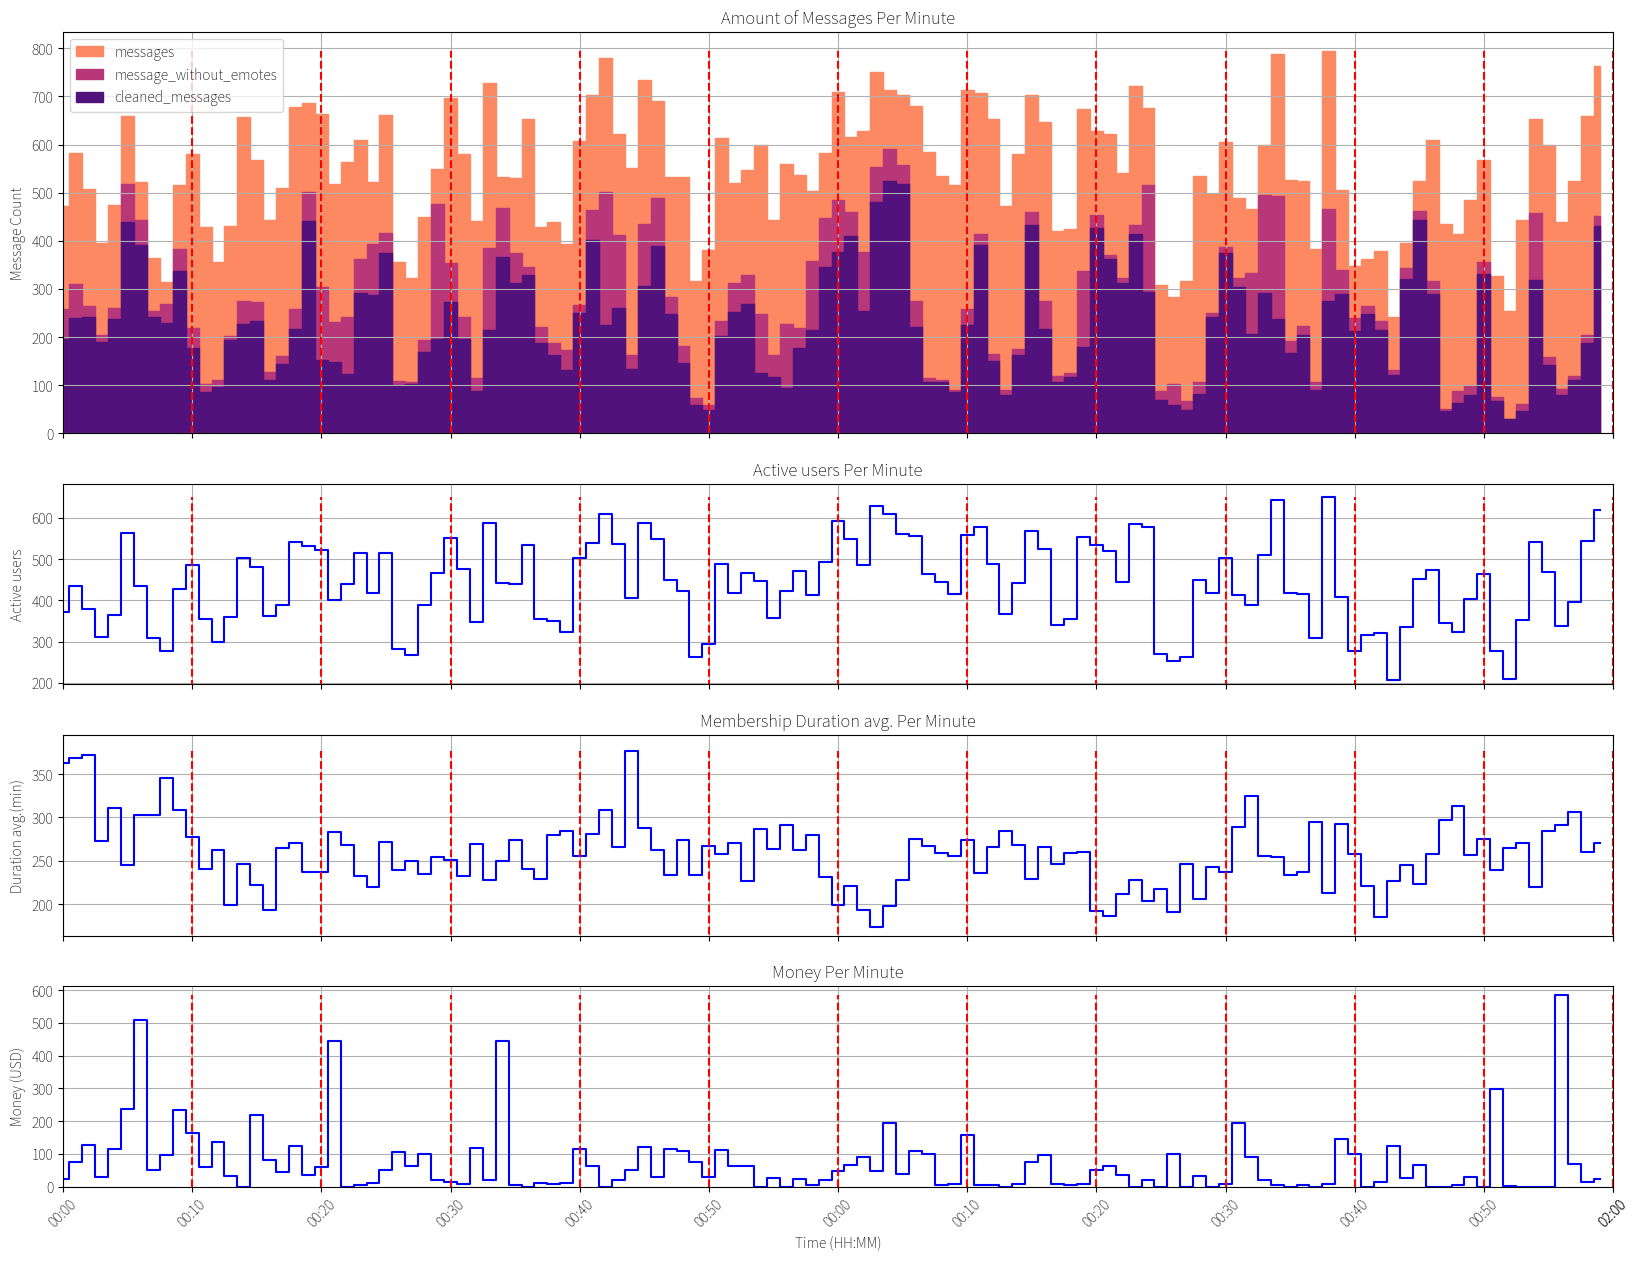

In [14]:
from stream_analysis.charts import ActivityPerMin


activity_per_min = ActivityPerMin(chat, env_)

In [15]:
chat.df_peaks

,time_in_minutes,active_users,membership_duration_avg,money_sum,messages,message_without_emotes,cleaned_messages,member_messages,messages_moving_avg,is_above_average
98,98,651,213.320755,9.010806,795,467,274,343,567.7,True


In [16]:
chat.activity_ranges

[(np.int64(1), np.int64(1)),
 (np.int64(5), np.int64(5)),
 (np.int64(9), np.int64(10)),
 (np.int64(14), np.int64(25)),
 (np.int64(29), np.int64(36)),
 (np.int64(40), np.int64(46)),
 (np.int64(51), np.int64(66)),
 (np.int64(70), np.int64(71)),
 (np.int64(75), np.int64(84)),
 (np.int64(88), np.int64(98)),
 (np.int64(105), np.int64(110)),
 (np.int64(114), np.int64(119))]

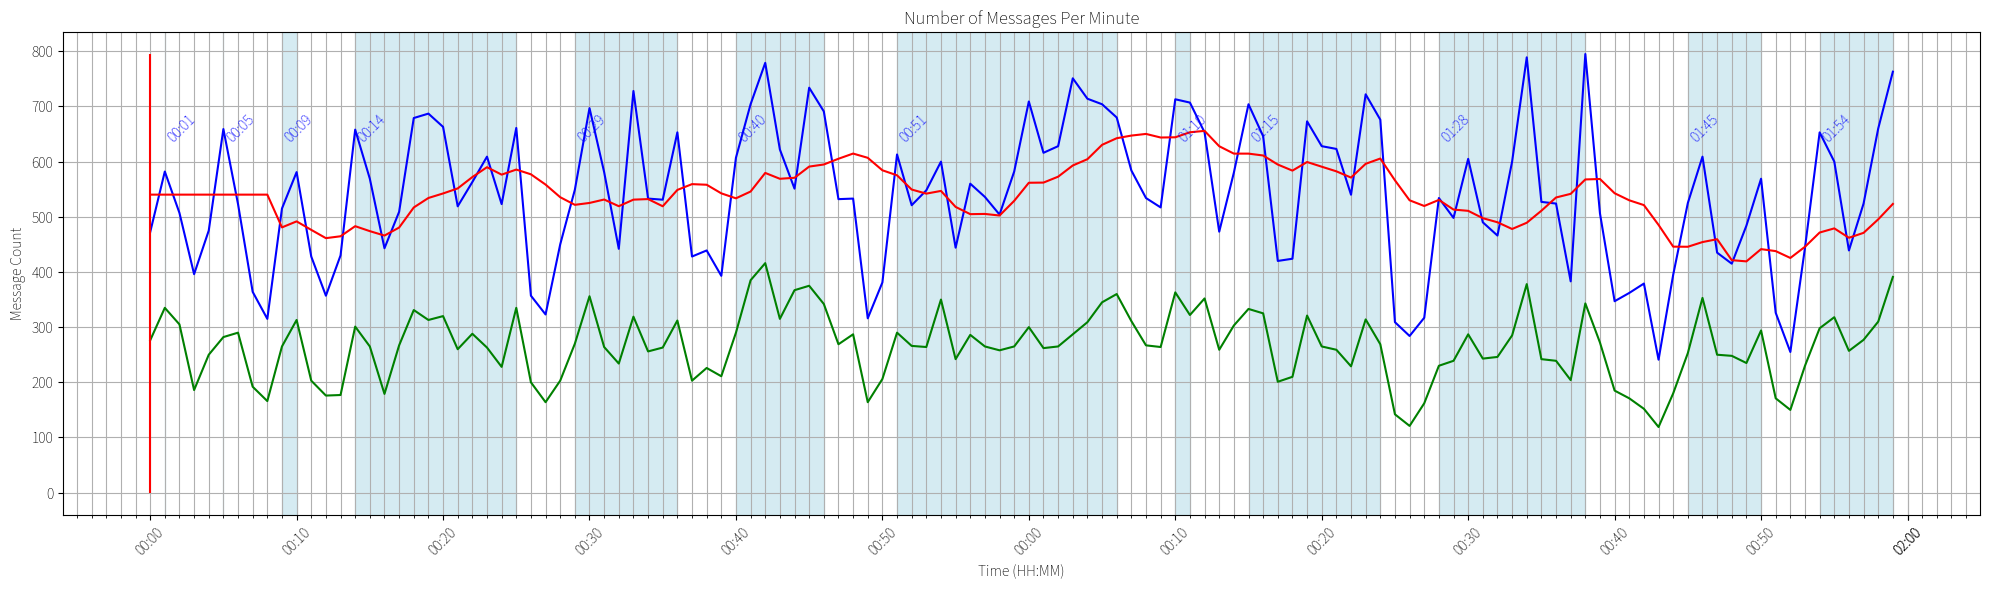

In [17]:
plt.figure(figsize=(20, 6))

plt.plot(chat.df_per_min['time_in_minutes'], chat.df_per_min['messages'], label='Total Messages', color='blue')

plt.plot(chat.df_per_min['time_in_minutes'], chat.df_per_min['member_messages'], label='Member Messages', color='green')

plt.plot(chat.df_per_min['time_in_minutes'], chat.df_per_min['messages_moving_avg'], label="Moving Average", color='red')

for start, end in chat.activity_ranges:
    plt.axvspan(start, end, color='lightblue', alpha=0.5)
    plt.text(start, chat.df_per_min['messages'].max() * 0.8, minutes_to_hhmm(start), color='blue', fontsize=10, rotation=45)

plt.vlines(0, ymin=0, ymax=chat.df_peaks['messages'].max(), colors='red')

plt.xticks(ticks=env_.time_labels[1], labels=env_.time_labels[0], rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.savefig(env_.chat_timeline_path)
plt.show()

In [18]:
# from stream_analysis.summary import Summary

# df_filtered = df[df['cleaned_message'].str.len() > 0]

# summary = Summary(env_, '\n'.join(df_filtered[['message']].to_numpy().flatten())).getContent()
# summary

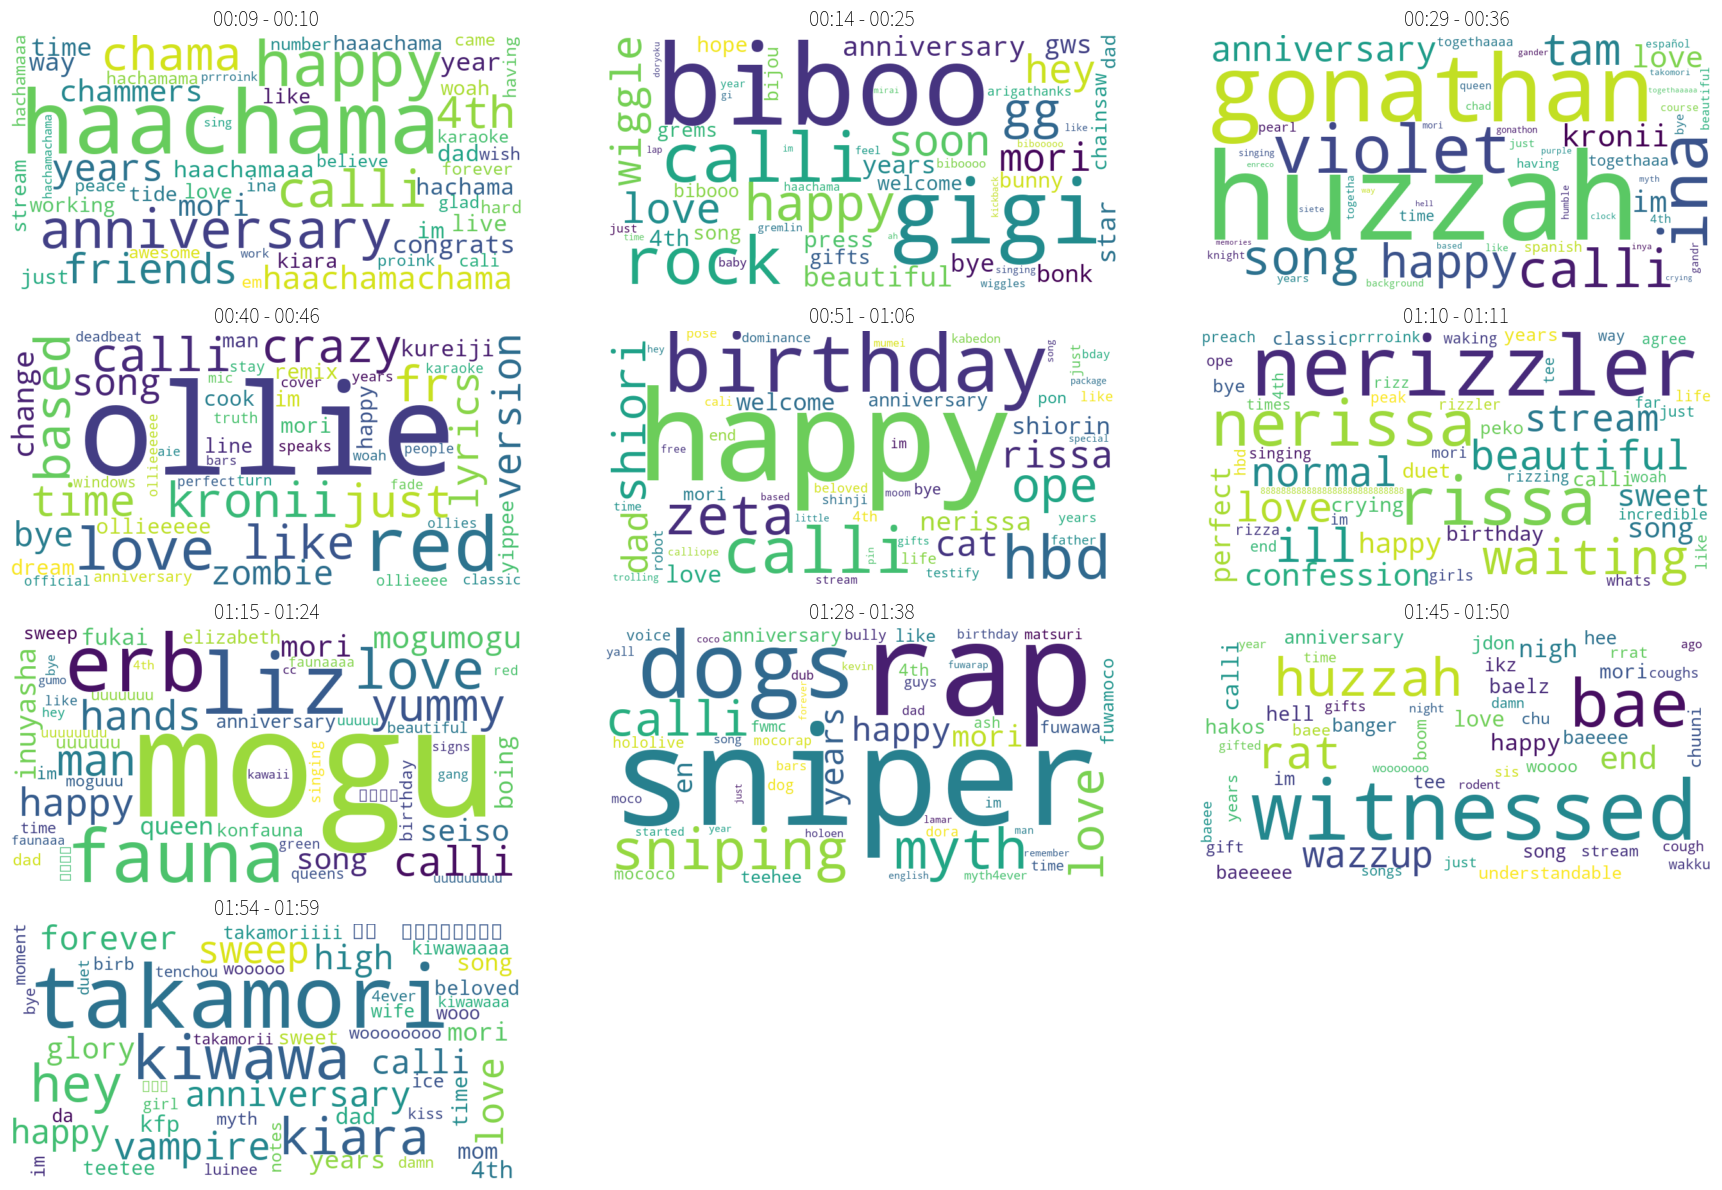

In [19]:
num_intervals = len(chat.activity_ranges)
cols = 3
rows = math.ceil(num_intervals / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 3 * rows))

index = -1
for i, time_range in enumerate(chat.activity_ranges):
    try:
        index += 1
        start = time_range[0] * 60
        end = time_range[1] * 60
        start_label = minutes_to_hhmm(time_range[0])
        end_label = minutes_to_hhmm(time_range[1])

        df_filtered = df[(df['time_in_seconds'] >= start) & (df['time_in_seconds'] <= end) & (df['cleaned_message'].str.len() > 0)]

        word_freq = get_word_freq(df_filtered['cleaned_message'])
        word_path = os.path.join(env_.data_path, f'{start_label}_{end_label}'.replace(':', '-'))
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, min_word_length=3).generate_from_frequencies(word_freq)

        df_filtered[['time_in_seconds', 'message']].to_csv(f'{word_path}_chat.csv', encoding='utf8', index=False)
        word_freq.to_csv(f'{word_path}_wfreq.csv', encoding='utf8', header=False)

        ax = axes[index // cols][index % cols] if rows > 1 else axes[index % cols]

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")

        ax.set_title(f'{start_label} - {end_label}', fontsize=14)
    except Exception as e:
        index -= 1
        continue

for j in range(index + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols] if rows > 1 else axes[j % cols])

plt.tight_layout()
plt.savefig(env_.chat_wordcloud_path)
plt.show()

In [20]:
font_name = os.getenv('DEFAULT_FONT_NAME')
font_path = f"{os.getenv('DEFAULT_FONT_PATH')}/{font_name}/{os.getenv('DEFAULT_FONT_FILENAME')}"
pdfmetrics.registerFont(TTFont(font_name, font_path, 'utf8'))

c = canvas.Canvas(os.path.join(env_.data_path, 'report.pdf'), pagesize=A4)

width, height = A4
cursor = height
margin = 8
available_width = width - 2 * margin

c.setFont(font_name, 16)

cursor = height - 32

text_width = c.stringWidth(env_.video_title)
x_position = (available_width - text_width) / 2  # 計算置中位置

c.drawString(x_position, cursor, env_.video_title)

c.setFont(font_name, 12)
cursor = cursor - 17
text_width = c.stringWidth(env_.video_liver)
x_position = (available_width - text_width)
c.drawString(x_position, cursor, env_.video_liver)

# cursor = cursor - 10
# cursor = draw_markdown_to_pdf(c, summary, cursor, margin, width, height, font_name)

image = ImageReader(env_.chat_timeline_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

image = ImageReader(env_.chat_wordcloud_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

c.save()
